### Image Preprocessing

This section prepares the image data to be used for analysis. Preprocessing operations done include:
* Resize images to 200x200
* Normalize pixel values to be between 0 and 1
* Flatten images into a 1d vector
* Rotate images 0, 90, 180, and 270 degrees

In [68]:
from os import listdir
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [89]:
#directory to a small subset of images to test preprocessing, uncomment directory to all images when needed
#data_dir = "F:\MIDS\w210 Capstone\dev_images"
data_dir = "F:\MIDS\w210 Capstone\weedeater\preliminary_data\\nikon_5600_perlite"

In [85]:
#GLOBAL VARS
FINAL_WIDTH = 200 #desired width (in pixels) to resize the image to
FINAL_HEIGHT = 200 #desired height (in pixels) to resize the image to
NUM_CHANNELS = 3 #number of channels 

In [86]:
data = []
label = []
rotation = []
file_names = []

def rotate_image(image_obj, degree = 0):
    (h, w) = image_obj.shape[:2]
    center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, degree, 1.0)
    rotated = cv2.warpAffine(image_obj, M, (w, h))
    #cv2.imshow("rotated", rotated)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    return rotated

def image_to_vector(image_obj, size = (FINAL_WIDTH, FINAL_HEIGHT)):
    '''takes an opencv image object and returns a generator for flattened vectors of the 
    image rotated by 0, 90, 180, and 270 degrees based on the dimensions specified in size
    
    the output vector is also normalized between 0 and 1
    '''
    #scale so values are between 0 and 1
    resized = cv2.resize(image_obj, size)
    for degree in [0, 90, 180, 270]:
        yield (rotate_image(resized, degree = degree).flatten()/255.0, degree)
    
def flat_to_2d(image_vector, size = (FINAL_WIDTH, FINAL_HEIGHT, NUM_CHANNELS)):
    '''given a normalized 1d array of an image,
    returns the original 3d array representation of the flattened image,
    dimensions of returned array are FINAL_WIDTH x FINAL_HEIGHT x NUM_CHANNELS'''
    flat = image_vector*255.0
    image = flat.astype(np.uint8).reshape(size)
    #cv2.imshow("test", image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    return image
    

In [91]:
for plant in listdir(data_dir):
    for image in listdir(f'{data_dir}\\{plant}'):
        for im in image_to_vector(cv2.imread(f'{data_dir}\\{plant}\\{image}')):
            d, r = im
            data.append(d)
            rotation.append(r)
            label.append(plant)
            file_names.append(image)

Text(0.5, 1.0, 'marigold')

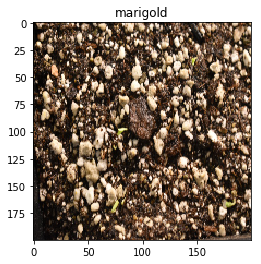

In [92]:
#test data and labels are correctly generated on an example
test = flat_to_2d(data[0])
img = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(label[0])

### Prepare Train/Validation/Test Split

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from copy import deepcopy

In [145]:
lb = LabelBinarizer()
label_transformer = deepcopy(lb.fit(label))

(x_train_features, x_test_features, 
 y_train, y_test, 
 train_rotation, test_rotation,
 train_filenames, test_filenames) = train_test_split(data, label, rotation, file_names,
                                                        test_size = 0.20,
                                                        random_state = 10298)

#convert labels to one-hot
y_test = label_transformer.transform(y_test)

#split off validation set from train set
(x_train_features, x_val_features,
 y_train, y_val,
 train_rotation, val_rotation,
 train_filenames, val_filenames) = train_test_split(x_train_features, y_train, train_rotation, train_filenames,
                                                    test_size = 0.15,
                                                    random_state = 1249)

#labels to one-hot
y_train = label_transformer.transform(y_train)
y_val = label_transformer.transform(y_val)

In [146]:
np.array(x_train_features).shape

(1653, 120000)

In [147]:
y_train.shape

(1653, 4)

In [148]:
np.array(x_val_features).shape

(292, 120000)

In [149]:
y_val.shape

(292, 4)

In [150]:
np.array(x_test_features).shape

(487, 120000)

In [151]:
y_test.shape

(487, 4)

### CNN

In [170]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from keras.optimizers import SGD
import keras

In [172]:
model = Sequential()
model.add(Dense(768,
                input_dim = 120000,
                kernel_initializer = "uniform",
                activation = "relu"))
model.add(Dense(384,
                activation = "relu",
                kernel_initializer = "uniform"))
model.add(Dense(4))
model.add(Activation("softmax"))
model.compile(loss = 'categorical_crossentropy',
              optimizer = SGD(lr = 0.01),
              metrics = ['accuracy'])

In [173]:
model.fit(np.array(x_train_features), 
          y_train, 
          batch_size = 20,
          epochs = 100,
          validation_data = (np.array(x_val_features), y_val))

Train on 1653 samples, validate on 292 samples
Epoch 1/100
1653/1653 [==============================] - 98s 59ms/step - loss: 11.7213 - acc: 0.2607 - val_loss: 11.5918 - val_acc: 0.2808
Epoch 2/100
1653/1653 [==============================] - 72s 44ms/step - loss: 11.7887 - acc: 0.2686 - val_loss: 11.5918 - val_acc: 0.2808
Epoch 3/100
1653/1653 [==============================] - 72s 44ms/step - loss: 11.7887 - acc: 0.2686 - val_loss: 11.5918 - val_acc: 0.2808
Epoch 4/100
1653/1653 [==============================] - 72s 43ms/step - loss: 11.7887 - acc: 0.2686 - val_loss: 11.5918 - val_acc: 0.2808
Epoch 5/100
1653/1653 [==============================] - 74s 45ms/step - loss: 11.7887 - acc: 0.2686 - val_loss: 11.5918 - val_acc: 0.2808
Epoch 6/100
1653/1653 [==============================] - 77s 47ms/step - loss: 11.7887 - acc: 0.2686 - val_loss: 11.5918 - val_acc: 0.2808
Epoch 7/100
1653/1653 [==============================] - 72s 44ms/step - loss: 11.7887 - acc: 0.2686 - val_loss: 11.591

KeyboardInterrupt: 

In [40]:
test_image = "F:\\MIDS\\w210 Capstone\\weedeater\\preliminary_data\\nikon_5600_perlite\\marigold\\S_E001_DSC_0064.jpg"
test_im = cv2.imread(test_image)
cv2.imshow("test", test_im)
cv2.waitKey(0)
cv2.destroyAllWindows()